In [129]:
import pandas as pd
import numpy as np

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf, lit

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler, VectorSlicer, Bucketizer
from pyspark.ml.linalg import Vectors

In [23]:
# setup spark
sc = pyspark.SparkContext()
ss = SparkSession(sc)

In [114]:
def ith_(v, i):
    try:
        return float(v[i])
    except ValueError:
        return None
ith = udf(ith_, DoubleType())

In [24]:
# get data
fil = './Ex_Files_Spark_ML_AI/Ch01/01_04/employee.txt'
emp_df = ss.read.csv(fil, header=True, inferSchema=True).cache()
# talk
print(emp_df.columns)
emp_df.printSchema()
emp_df.show()
print(emp_df.count())

['id', 'last_name', 'email', 'gender', 'department', 'start_date', 'salary', 'job_title', 'region_id']
root
 |-- id: integer (nullable = true)
 |-- last_name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- department: string (nullable = true)
 |-- start_date: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- job_title: string (nullable = true)
 |-- region_id: integer (nullable = true)

+---+------------+--------------------+--------+-------------+------------+------+--------------------+---------+
| id|   last_name|               email|  gender|   department|  start_date|salary|           job_title|region_id|
+---+------------+--------------------+--------+-------------+------------+------+--------------------+---------+
|  1|    'Kelley'|'rkelley0@soundcl...|'Female'|  'Computers'| '10/2/2009'| 67470|'Structural Engin...|        2|
|  2| 'Armstrong'|'sarmstrong1@info...|  'Male'|     'Sports'| '3/31/2008'| 71

In [25]:
# get a random sample
samp_df = emp_df.sample(withReplacement=False, fraction=0.2, seed=42).cache() # sampling is approximate!
samp_df.count()

197

In [26]:
emp_df.filter(emp_df.salary>=100000).show()

+---+-----------+--------------------+--------+-------------+------------+------+--------------------+---------+
| id|  last_name|               email|  gender|   department|  start_date|salary|           job_title|region_id|
+---+-----------+--------------------+--------+-------------+------------+------+--------------------+---------+
|  3|     'Carr'|'fcarr2@woothemes...|  'Male'| 'Automotive'| '7/12/2009'|101768|'Recruiting Manager'|        3|
|  6| 'Phillips'|'bphillips5@time....|  'Male'|      'Tools'| '8/21/2013'|118497|'Executive Secret...|        1|
|  9|    'James'|'rjames8@prnewswi...|  'Male'|   'Jewelery'|  '9/7/2005'|108657|   'Sales Associate'|        2|
| 10|  'Sanchez'|'rsanchez9@cloudf...|  'Male'|     'Movies'| '3/13/2013'|108093|'Sales Representa...|        1|
| 11|   'Jacobs'|'jjacobsa@sbwire....|'Female'|   'Jewelery'|'11/27/2003'|121966|'Community Outrea...|        7|
| 15|   'Jacobs'|'ajacobse@google.it'|'Female'|      'Games'|  '3/4/2007'|141139|'Community Outr

array([[<AxesSubplot:title={'center':'salary'}>]], dtype=object)

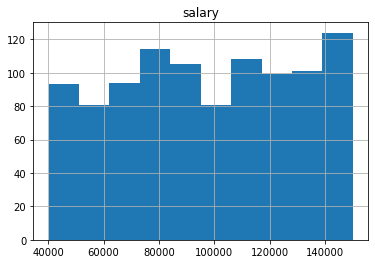

In [27]:
# use pandas for a quick histogram of salaries
emp_df.select('salary').toPandas().hist()

In [117]:
# make a dense features dataframe
va = VectorAssembler(inputCols=['salary'], outputCol='features')
features_df = va.transform(emp_df)
features_df.show()

+---+------------+--------------------+--------+-------------+------------+------+--------------------+---------+----------+
| id|   last_name|               email|  gender|   department|  start_date|salary|           job_title|region_id|  features|
+---+------------+--------------------+--------+-------------+------------+------+--------------------+---------+----------+
|  1|    'Kelley'|'rkelley0@soundcl...|'Female'|  'Computers'| '10/2/2009'| 67470|'Structural Engin...|        2| [67470.0]|
|  2| 'Armstrong'|'sarmstrong1@info...|  'Male'|     'Sports'| '3/31/2008'| 71869| 'Financial Advisor'|        2| [71869.0]|
|  3|      'Carr'|'fcarr2@woothemes...|  'Male'| 'Automotive'| '7/12/2009'|101768|'Recruiting Manager'|        3|[101768.0]|
|  4|    'Murray'|   'jmurray3@gov.uk'|'Female'|   'Jewelery'|'12/25/2014'| 96897|'Desktop Support ...|        3| [96897.0]|
|  5|     'Ellis'|'jellis4@scienced...|'Female'|    'Grocery'| '9/19/2002'| 63702|'Software Enginee...|        7| [63702.0]|


In [118]:
# try min-max scaling
scal = MinMaxScaler(inputCol='features', outputCol='sfeatures')
sfeatures_df = scal.fit(features_df).transform(features_df).cache()
sfeatures_df.show()

+---+------------+--------------------+--------+-------------+------------+------+--------------------+---------+----------+--------------------+
| id|   last_name|               email|  gender|   department|  start_date|salary|           job_title|region_id|  features|           sfeatures|
+---+------------+--------------------+--------+-------------+------------+------+--------------------+---------+----------+--------------------+
|  1|    'Kelley'|'rkelley0@soundcl...|'Female'|  'Computers'| '10/2/2009'| 67470|'Structural Engin...|        2| [67470.0]|[0.24894572414860...|
|  2| 'Armstrong'|'sarmstrong1@info...|  'Male'|     'Sports'| '3/31/2008'| 71869| 'Financial Advisor'|        2| [71869.0]|[0.2890127606087931]|
|  3|      'Carr'|'fcarr2@woothemes...|  'Male'| 'Automotive'| '7/12/2009'|101768|'Recruiting Manager'|        3|[101768.0]| [0.561339271889317]|
|  4|    'Murray'|   'jmurray3@gov.uk'|'Female'|   'Jewelery'|'12/25/2014'| 96897|'Desktop Support ...|        3| [96897.0]|

array([[<AxesSubplot:title={'center':'salary'}>]], dtype=object)

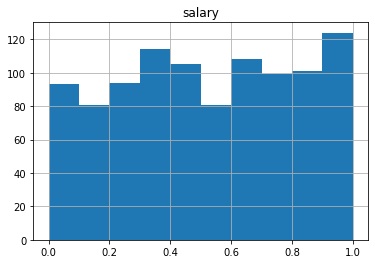

In [119]:
# histogram
sfeatures_df.select(ith("sfeatures", lit(0))).withColumnRenamed('ith_(sfeatures, 0)', 'salary').toPandas().hist()

In [120]:
# try standard scaling
scal = StandardScaler(inputCol='features', outputCol='nfeatures', withMean=True, withStd=True)
sfeatures_df = scal.fit(sfeatures_df).transform(sfeatures_df).cache()
sfeatures_df.show()

+---+------------+--------------------+--------+-------------+------------+------+--------------------+---------+----------+--------------------+--------------------+
| id|   last_name|               email|  gender|   department|  start_date|salary|           job_title|region_id|  features|           sfeatures|           nfeatures|
+---+------------+--------------------+--------+-------------+------------+------+--------------------+---------+----------+--------------------+--------------------+
|  1|    'Kelley'|'rkelley0@soundcl...|'Female'|  'Computers'| '10/2/2009'| 67470|'Structural Engin...|        2| [67470.0]|[0.24894572414860...|[-0.9404188679633...|
|  2| 'Armstrong'|'sarmstrong1@info...|  'Male'|     'Sports'| '3/31/2008'| 71869| 'Financial Advisor'|        2| [71869.0]|[0.2890127606087931]|[-0.8018812534734...|
|  3|      'Carr'|'fcarr2@woothemes...|  'Male'| 'Automotive'| '7/12/2009'|101768|'Recruiting Manager'|        3|[101768.0]| [0.561339271889317]|[0.13972732475646...

array([[<AxesSubplot:title={'center':'salary'}>]], dtype=object)

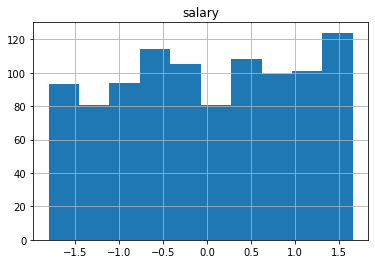

In [121]:
# histogram
sfeatures_df.select(ith("nfeatures", lit(0))).withColumnRenamed('ith_(nfeatures, 0)', 'salary').toPandas().hist()

In [132]:
# discretization
discBoundaries = emp_df.select('salary').toPandas().quantile([0.0, 0.25, 0.5, 0.75, 1]).values.flatten().tolist()
disc = Bucketizer(inputCol='salary', outputCol='bfeatures', splits=discBoundaries)
sfeatures_df = disc.transform(sfeatures_df).cache()
sfeatures_df.show()

+---+------------+--------------------+--------+-------------+------------+------+--------------------+---------+----------+--------------------+--------------------+---------+
| id|   last_name|               email|  gender|   department|  start_date|salary|           job_title|region_id|  features|           sfeatures|           nfeatures|bfeatures|
+---+------------+--------------------+--------+-------------+------------+------+--------------------+---------+----------+--------------------+--------------------+---------+
|  1|    'Kelley'|'rkelley0@soundcl...|'Female'|  'Computers'| '10/2/2009'| 67470|'Structural Engin...|        2| [67470.0]|[0.24894572414860...|[-0.9404188679633...|      0.0|
|  2| 'Armstrong'|'sarmstrong1@info...|  'Male'|     'Sports'| '3/31/2008'| 71869| 'Financial Advisor'|        2| [71869.0]|[0.2890127606087931]|[-0.8018812534734...|      1.0|
|  3|      'Carr'|'fcarr2@woothemes...|  'Male'| 'Automotive'| '7/12/2009'|101768|'Recruiting Manager'|        3|[1

array([[<AxesSubplot:title={'center':'bfeatures'}>]], dtype=object)

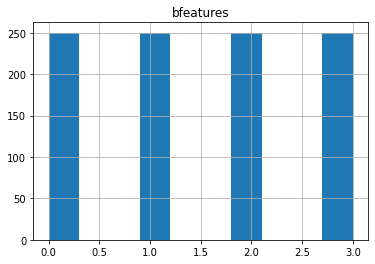

In [133]:
# histogram - of course they're all even
sfeatures_df.select('bfeatures').toPandas().hist()

In [19]:
sc.close()